In [45]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer,mean_squared_log_error
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.preprocessing import FunctionTransformer,StandardScaler,MinMaxScaler,OneHotEncoder


In [2]:
from sklearn import set_config;set_config(display='diagram')

In [3]:
train = pd.read_csv('../raw_data/Kaggle_House_train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
X = train.drop(columns = ['SalePrice','Id'])
y = train['SalePrice']

## Baseline Model

### Feature Engineering

In [5]:
# numerical features
num_features = X.select_dtypes(include = ['int','float']).columns
len(num_features)

36

In [6]:
# categorical features
cat_features = X.select_dtypes(exclude=['int','float']).columns
len(cat_features)

43

In [7]:
cat_features_nunique = X.select_dtypes(exclude=['int','float']).nunique()
cat_features_nunique.sum()

252

<AxesSubplot:>

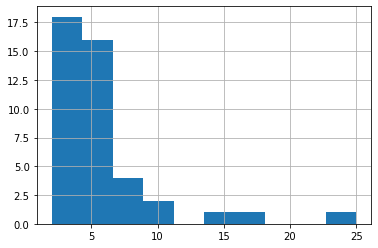

In [8]:
cat_features_nunique.hist()

In [9]:
cat_features_less = cat_features_nunique.where(lambda x:x<7).dropna()

In [10]:
cat_features_less_col = cat_features_less.index
len(cat_features_less_col)

34

In [11]:
cat_features_more = cat_features_nunique.where(lambda x:x>=7).dropna()

In [12]:
cat_features_more_col = cat_features_more.index
len(cat_features_more_col)

9

### Pipeline

In [13]:
# numerical features
num_transformer = make_pipeline(SimpleImputer(),MinMaxScaler())
num_col = make_column_selector(dtype_include=['int64','float64'])

In [14]:
# categorical features
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                OneHotEncoder(handle_unknown='ignore',sparse=False))
cat_col = make_column_selector(dtype_exclude=['int64','float64'])

In [15]:
# make pipeline
preproc_baseline = make_column_transformer((num_transformer,num_col),
                                           (cat_transformer,cat_col),
                                           remainder='drop')


In [16]:
# fit model to X and y
X.drop(columns = ['Neighborhood', 'Condition1', 'Condition2', 'HouseStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'Functional', 'SaleType'],inplace = True)


In [17]:
preproc_X = pd.DataFrame(preproc_baseline.fit_transform(X))
shape_preproc_baseline = preproc_X.shape
shape_preproc_baseline

(1460, 183)

### Model Evaluation

In [18]:
model_baseline = make_pipeline(preproc_baseline,DecisionTreeRegressor())

In [23]:
rmsle = make_scorer(mean_squared_log_error,squared=False)
rsmle_neg = make_scorer(mean_squared_log_error,squared=False,greater_is_better=False)

# # This is our metric to minimize
# rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# # This is our score to maximize
# rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

# # Equivalent formulation
# rmsle_neg = make_scorer(
#     lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5,
#     greater_is_better=False
# )

In [24]:
score_baseline = cross_val_score(model_baseline,X,y,cv=5).mean()
score_baseline

0.7054460027337559

### Model Prediction

In [35]:
test = pd.read_csv('../raw_data/Kaggle_House_test.csv')
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [36]:
test.drop(columns = ['Neighborhood', 'Condition1', 'Condition2', 'HouseStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'Functional', 'SaleType'],inplace = True)

In [37]:
model_baseline.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10c4cd7f0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14cf6a820>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [38]:
y_pred_baseline = model_baseline.predict(test)

/Users/yanyi/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


In [39]:
test['SalePrice'] = y_pred_baseline

In [41]:
df_baseline_predict = test[['Id','SalePrice']]
df_baseline_predict

,Id,SalePrice
0,1461,129000.0
1,1462,157900.0
2,1463,210000.0
3,1464,175500.0
4,1465,212000.0
...,...,...
1454,2915,84500.0
1455,2916,79900.0
1456,2917,142500.0
1457,2918,93500.0


In [43]:
# export predict csv
df_baseline_predict.to_csv('../raw_data/Kaggle_baseline_predict.csv',index=False)

## Improve Model

###  Feature Engineering

In [51]:
dict_ordinal = {
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
    
}

In [54]:
feat_ordinal = sorted(dict_ordinal.keys())
feat_ordinal_sorted = [dict_ordinal[i] for i in feat_ordinal]

In [56]:
ore = OrdinalEncoder(
    categories=feat_ordinal_sorted,
    dtype=np.int64,
    handle_unknown = 'use_encoded_value',
    unknown_value=-1
)

TypeError: __init__() got an unexpected keyword argument 'handle_unknown'

###  Pipeline

### Target Engineering

### Model Evaluation

### Model Prediction